# IBM Capstone Course Project - Code

Import libraries.

In [3]:
from bs4 import BeautifulSoup              # Import BeautifulSoup to pull data out of HTML files
from geopy.geocoders import Nominatim      # Import Nominatim to convert address into latitude and longitude values

import requests                            # Import requests to to send HTTP requests
import numpy as np                         # library to handle data in a vectorized manner

import pandas as pd                        # Import pandas to convert list to data frame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans         # import k-means from clustering stage

import folium                              # map rendering library
import json                                # library to handle JSON files

import matplotlib.cm as cm                 # Matplotlib and associated plotting modules
import matplotlib.colors as colors

print('Libraries imported.')

Libraries imported.


## Data Sources

### Load and Process New York City Data

Load the NYC data from the jason file that was downloaded from the NYU Spatial Data Repository.

In [4]:
with open(r'datasets\nyc-geojson.json') as json_data:
    nyc_data = json.load(json_data)
    
nyc_data # examine the data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Define a new variable that includes this features data.

In [5]:
nyc_neighborhoods_data = nyc_data['features']

# look at the first item in the list
nyc_neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Transform this data of nested Python dictionaries into a pandas dataframe. Begin by creating an empty dataframe.

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nyc_neighborhoods = pd.DataFrame(columns=column_names)

# examine the empty dataframe to confirm that the columns are as intended.
nyc_neighborhoods

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

Loop through the data and fill the dataframe one row at a time.

In [7]:
for data in nyc_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_neighborhoods = nyc_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


Examine the resulting dataframe.

In [8]:
nyc_neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

Make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nyc_neighborhoods['Borough'].unique()),
        nyc_neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Load and Process City of Toronto Data

Assign the website's link to a variable, using requests to get its HTML.

In [10]:
website_url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text

Parse the document. Print out the page's HTML, using the prettify.

In [11]:
soup = BeautifulSoup(website_url, 'lxml')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
  </script>
  <script>
   (window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":876823784,"wgRevisionId":876823784,"wgArticleId":539066,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communications in Ontario","Postal codes in Canada","Toronto","Ontario-related lists"],"wgBreakFrames":false,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wg

Find the class 'wikitable sortable' in the HTML script.

In [12]:
My_table = soup.find('table',{'class':'wikitable sortable'})

Iterate through each row (tr), assign each element (td) to a variable, append it to a list, and then create the dataframe.

In [13]:
# Generate lists
A=[]
B=[]
C=[]

for row in My_table.findAll("tr"):
    cells = row.findAll('td')
    if len(cells)==3:
               
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))

# Convert lists to a dataframe
PostalCodes=pd.DataFrame(A,columns=['PostalCode'])
PostalCodes['Borough']=B
PostalCodes['Neighborhood']=C

Clean the dataframe.

Remove the 'Not assigned' Borough values.

In [14]:
PostalCodes = PostalCodes[PostalCodes['Borough']!='Not assigned']
PostalCodes.reset_index(drop=True, inplace=True)

Combine neighborhoods that are in the same postal code.

In [17]:
PostalCodes = PostalCodes.groupby(['PostalCode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
PostalCodes['Neighborhood'] = PostalCodes['Neighborhood'].replace({'\n': ''}, regex = True)

Change the Neighborhood value from 'Not assigned' to its respective Borough name. Print the dataframe.

In [18]:
PostalCodes.at[85, 'Neighborhood'] = "Queen's Park"
PostalCodes

PostalCode           Borough  \
0          M1B       Scarborough   
1          M1C       Scarborough   
2          M1E       Scarborough   
3          M1G       Scarborough   
4          M1H       Scarborough   
5          M1J       Scarborough   
6          M1K       Scarborough   
7          M1L       Scarborough   
8          M1M       Scarborough   
9          M1N       Scarborough   
10         M1P       Scarborough   
11         M1R       Scarborough   
12         M1S       Scarborough   
13         M1T       Scarborough   
14         M1V       Scarborough   
15         M1W       Scarborough   
16         M1X       Scarborough   
17         M2H        North York   
18         M2J        North York   
19         M2K        North York   
20         M2L        North York   
21         M2M        North York   
22         M2N        North York   
23         M2P        North York   
24         M2R        North York   
25         M3A        North York   
26         M3B        North York   
27         M3C        North York   
28         M3H        North York   
29         M3J        North York   
30         M3K        North York   
31         M3L        North York   
32         M3M        North York   
33         M3N        North York   
34         M4A        North York   
35         M4B         East York   
36         M4C         East York   
37         M4E      East Toronto   
38         M4G         East York   
39         M4H         East York   
40         M4J         East York   
41         M4K      East Toronto   
42         M4L      East Toronto   
43         M4M      East Toronto   
44         M4N   Central Toronto   
45         M4P   Central Toronto   
46         M4R   Central Toronto   
47         M4S   Central Toronto   
48         M4T   Central Toronto   
49         M4V   Central Toronto   
50         M4W  Downtown Toronto   
51         M4X  Downtown Toronto   
52         M4Y  Downtown Toronto   
53         M5A  Downtown Toronto   
54         M5B  Downtown Toronto   
55         M5C  Downtown Toronto   
56         M5E  Downtown Toronto   
57         M5G  Downtown Toronto   
58         M5H  Downtown Toronto   
59         M5J  Downtown Toronto   
60         M5K  Downtown Toronto   
61         M5L  Downtown Toronto   
62         M5M        North York   
63         M5N   Central Toronto   
64         M5P   Central Toronto   
65         M5R   Central Toronto   
66         M5S  Downtown Toronto   
67         M5T  Downtown Toronto   
68         M5V  Downtown Toronto   
69         M5W  Downtown Toronto   
70         M5X  Downtown Toronto   
71         M6A        North York   
72         M6B        North York   
73         M6C              York   
74         M6E              York   
75         M6G  Downtown Toronto   
76         M6H      West Toronto   
77         M6J      West Toronto   
78         M6K      West Toronto   
79         M6L        North York   
80         M6M              York   
81         M6N              York   
82         M6P      West Toronto   
83         M6R      West Toronto   
84         M6S      West Toronto   
85         M7A      Queen's Park   
86         M7R       Mississauga   
87         M7Y      East Toronto   
88         M8V         Etobicoke   
89         M8W         Etobicoke   
90         M8X         Etobicoke   
91         M8Y         Etobicoke   
92         M8Z         Etobicoke   
93         M9A         Etobicoke   
94         M9B         Etobicoke   
95         M9C         Etobicoke   
96         M9L        North York   
97         M9M        North York   
98         M9N              York   
99         M9P         Etobicoke   
100        M9R         Etobicoke   
101        M9V         Etobicoke   
102        M9W         Etobicoke   

                                          Neighborhood  
0                                       Rouge, Malvern  
1               Highland Creek, Rouge Hill, Port Union  
2                    Guildwood, Morningside, West Hill  
3                              

Use .shape to print the dataframe's number of rows. This dataframe has 103 rows.

In [19]:
PostalCodes.shape

(103, 3)

Read Excel spreadsheet into a dataframe.

In [20]:
DataFile = 'datasets\GeocodedData.xlsx'                    # Define a variable for the Geocoded data file
toronto_city_data = pd.read_excel(DataFile,       # Read the Excel spreadsheet into the dataframe
sheet_name=0,
header=0,
index_col=False,
keep_default_na=True
)

toronto_city_data

PostalCode           Borough  \
0          M1B       Scarborough   
1          M1C       Scarborough   
2          M1E       Scarborough   
3          M1G       Scarborough   
4          M1H       Scarborough   
5          M1J       Scarborough   
6          M1K       Scarborough   
7          M1L       Scarborough   
8          M1M       Scarborough   
9          M1N       Scarborough   
10         M1P       Scarborough   
11         M1R       Scarborough   
12         M1S       Scarborough   
13         M1T       Scarborough   
14         M1V       Scarborough   
15         M1W       Scarborough   
16         M1X       Scarborough   
17         M2H        North York   
18         M2J        North York   
19         M2K        North York   
20         M2L        North York   
21         M2M        North York   
22         M2N        North York   
23         M2P        North York   
24         M2R        North York   
25         M3A        North York   
26         M3B        North York   
27         M3C        North York   
28         M3H        North York   
29         M3J        North York   
30         M3K        North York   
31         M3L        North York   
32         M3M        North York   
33         M3N        North York   
34         M4A        North York   
35         M4B         East York   
36         M4C         East York   
37         M4E      East Toronto   
38         M4G         East York   
39         M4H         East York   
40         M4J         East York   
41         M4K      East Toronto   
42         M4L      East Toronto   
43         M4M      East Toronto   
44         M4N   Central Toronto   
45         M4P   Central Toronto   
46         M4R   Central Toronto   
47         M4S   Central Toronto   
48         M4T   Central Toronto   
49         M4V   Central Toronto   
50         M4W  Downtown Toronto   
51         M4X  Downtown Toronto   
52         M4Y  Downtown Toronto   
53         M5A  Downtown Toronto   
54         M5B  Downtown Toronto   
55         M5C  Downtown Toronto   
56         M5E  Downtown Toronto   
57         M5G  Downtown Toronto   
58         M5H  Downtown Toronto   
59         M5J  Downtown Toronto   
60         M5K  Downtown Toronto   
61         M5L  Downtown Toronto   
62         M5M        North York   
63         M5N   Central Toronto   
64         M5P   Central Toronto   
65         M5R   Central Toronto   
66         M5S  Downtown Toronto   
67         M5T  Downtown Toronto   
68         M5V  Downtown Toronto   
69         M5W  Downtown Toronto   
70         M5X  Downtown Toronto   
71         M6A        North York   
72         M6B        North York   
73         M6C              York   
74         M6E              York   
75         M6G  Downtown Toronto   
76         M6H      West Toronto   
77         M6J      West Toronto   
78         M6K      West Toronto   
79         M6L        North York   
80         M6M              York   
81         M6N              York   
82         M6P      West Toronto   
83         M6R      West Toronto   
84         M6S      West Toronto   
85         M7A      Queen's Park   
86         M7R       Mississauga   
87         M7Y      East Toronto   
88         M8V         Etobicoke   
89         M8W         Etobicoke   
90         M8X         Etobicoke   
91         M8Y         Etobicoke   
92         M8Z         Etobicoke   
93         M9A         Etobicoke   
94         M9B         Etobicoke   
95         M9C         Etobicoke   
96         M9L        North York   
97         M9M        North York   
98         M9N              York   
99         M9P         Etobicoke   
100        M9R         Etobicoke   
101        M9V         Etobicoke   
102        M9W         Etobicoke   

                                          Neighborhood   Latitude  Longitude  
0                                       Rouge, Malvern  43.806686 -79.194353  
1               Highland Creek, Rouge Hill, Port Union  43.784535 -79.160497  
2                    G

Check the number of boroughs and neighborhoods.

In [21]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_city_data['Borough'].unique()),
        toronto_city_data.shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighborhoods.


## Methodology

### Analysis of New York City Neighborhood (Subject's Current Residence)

#### Map the neighborhood's location

Use geopy library to get the latitude and longitude values for New York City.

In [64]:
address = 'New York City, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates New York City are {}, {}.'.format(latitude, longitude))

C:\Users\micha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinates New York City are 40.7308619, -73.9871558.


Isolate data regarding the East Village into its own DataFrame

In [63]:
east_village = nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == 'East Village'].reset_index(drop=True)
east_village.head()

Borough  Neighborhood   Latitude  Longitude
0  Manhattan  East Village  40.727847 -73.982226

Create a map of New York City with the East Village superimposed on top.

In [83]:
# create map of Manhattan showing the East Village using latitude and longitude values
map_east_village = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough, neighborhood in zip(east_village['Latitude'], east_village['Longitude'], east_village['Borough'], east_village['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_east_village)  
    

map_east_village.save('east village.html')    
    
map_east_village

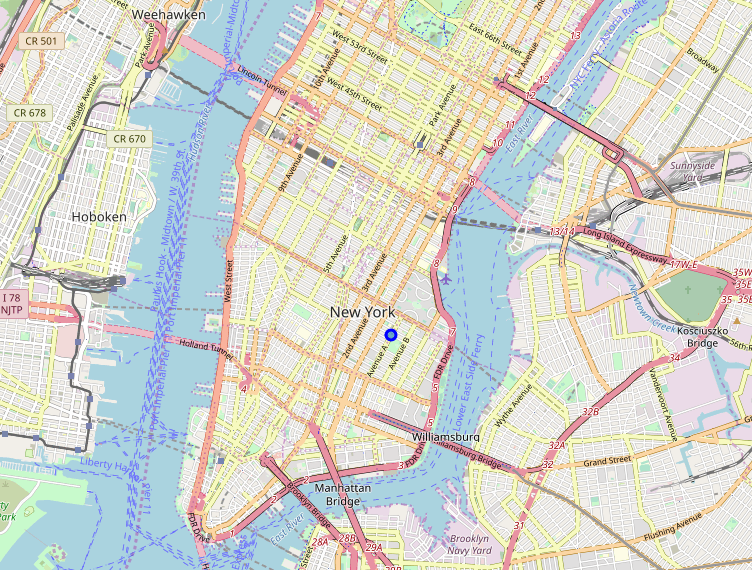

In [1]:
from IPython.display import Image
Image(filename='east_village.png')

Utilize the Foursquare API to explore the venues around the East Village.

#### Discover Venues Around the East Village

Define Foursquare Credentials and Version

In [86]:
CLIENT_ID = 'XXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


Get the neighborhood's name, latitude, and longitude values.

In [89]:
east_village_name = east_village.loc[0, 'Neighborhood']    # neighborhood name
east_village_latitude = east_village.loc[0, 'Latitude']    # neighborhood latitude value
east_village_longitude = east_village.loc[0, 'Longitude']  # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(east_village_name, 
                                                               east_village_latitude, 
                                                               east_village_longitude))



Latitude and longitude values of East Village are 40.727846777270244, -73.98222616506416.


Get the top 100 venues that are in the East Village within a radius of 500 meters.

Create the GET request URL.

In [93]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    east_village_latitude, 
    east_village_longitude, 
    radius, 
    LIMIT)

Send the GET request and examine the results.

In [95]:
east_village_results = requests.get(url).json()
east_village_results

{'meta': {'code': 200, 'requestId': '5c4f6e224434b9740d7d2337'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'East Village',
  'headerFullLocation': 'East Village, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 226,
  'suggestedBounds': {'ne': {'lat': 40.73234678177025,
    'lng': -73.97629913966246},
   'sw': {'lat': 40.72334677277024, 'lng': -73.98815319046587}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4cb34b64aef16dcb6287c754',
       'name': 'Good Beer NYC',
       'location': {'address': '422 E 9th St',
        'crossStreet': 'btwn Avenue A & 1st Ave',
        'lat': 40.727643,
        'lng': -73.9

Borrow the **get_category_type** function from the Foursquare lab.

In [96]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean the json and structure it into a *pandas* dataframe.

In [100]:
nyc_venues = east_village_results['response']['groups'][0]['items']
    
nearby_east_village_venues = json_normalize(nyc_venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_east_village_venues = nearby_east_village_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_east_village_venues['venue.categories'] = nearby_east_village_venues.apply(get_category_type, axis=1)

# clean columns
nearby_east_village_venues.columns = [col.split(".")[-1] for col in nearby_east_village_venues.columns]

nearby_east_village_venues.head()

name           categories        lat        lng
0                 Good Beer NYC           Beer Store  40.727643 -73.983835
1                  Cafe Mogador  Moroccan Restaurant  40.727293 -73.984517
2                          Kura  Japanese Restaurant  40.726803 -73.983444
3  Tompkins Square Park Dog Run              Dog Run  40.726482 -73.981204
4        Tompkins Square Bagels           Bagel Shop  40.728243 -73.982127

And how many venues were returned by Foursquare?

In [102]:
print('{} venues were returned by Foursquare.'.format(nearby_east_village_venues.shape[0]))

100 venues were returned by Foursquare.


Map of the East Villiage with venues.

In [256]:
# create map of the east villiage
map_east_village_venues = folium.Map(location=[east_village_latitude, east_village_longitude], zoom_start=17)
# add markers to map
for lat, lng, label in zip(nearby_east_village_venues['lat'], nearby_east_village_venues['lng'], nearby_east_village_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=30,
        radius=7,
        popup=label,
        color='red',
        fill_color='pink',
        fill_opacity=0.6,
    ).add_to(map_east_village_venues)  
    
map_east_village_venues.save('east_village_venues.html') 
    
map_east_village_venues

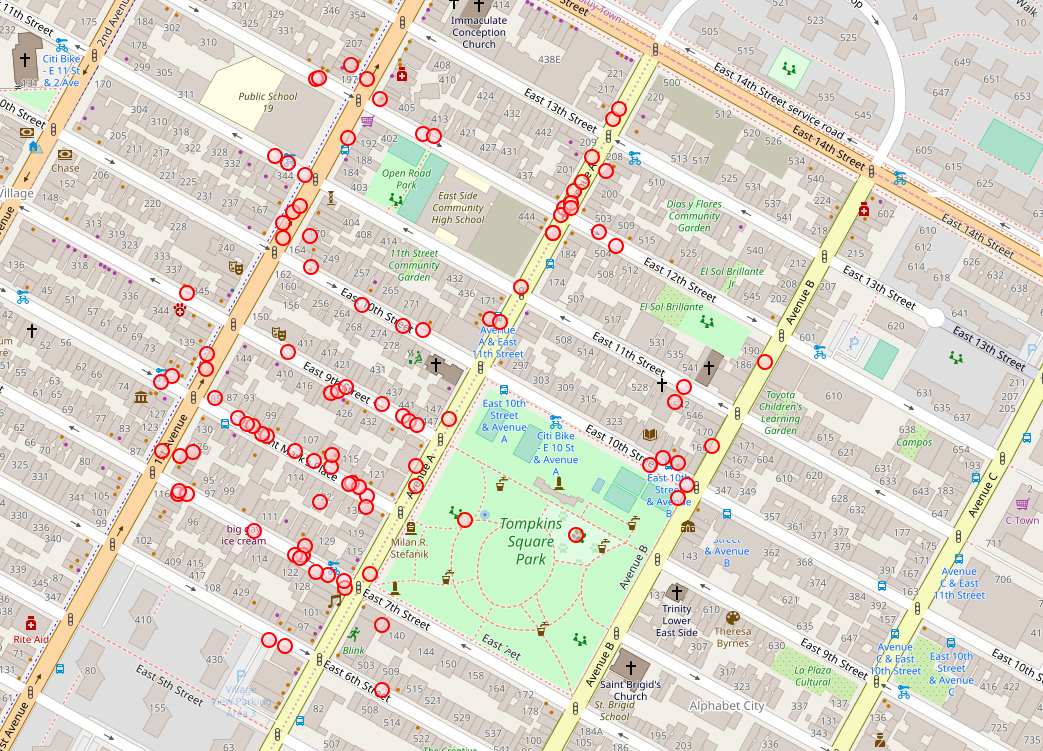

In [2]:
Image(filename='east_village_venues.png')

In [116]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [117]:
east_village_venues_combined = getNearbyVenues(names=east_village['Neighborhood'],
                                   latitudes=east_village['Latitude'],
                                   longitudes=east_village['Longitude']
                                  )

East Village


Combine neighborhood and venue information into one dataframe.

In [118]:
east_village_venues_combined.head()

(100, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  East Village              40.727847              -73.982226   
1  East Village              40.727847              -73.982226   
2  East Village              40.727847              -73.982226   
3  East Village              40.727847              -73.982226   
4  East Village              40.727847              -73.982226   

                          Venue  Venue Latitude  Venue Longitude  \
0                 Good Beer NYC       40.727643       -73.983835   
1                  Cafe Mogador       40.727293       -73.984517   
2                          Kura       40.726803       -73.983444   
3  Tompkins Square Park Dog Run       40.726482       -73.981204   
4        Tompkins Square Bagels       40.728243       -73.982127   

        Venue Category  
0           Beer Store  
1  Moroccan Restaurant  
2  Japanese Restaurant  
3              Dog Run  
4           Bagel Shop

See how many unique categories can be curated from the East Village.

In [120]:
print('There are {} unique categories.'.format(len(east_village_venues_combined['Venue Category'].unique())))

There are 58 unique categories.


Analyze the East Villiage neighborhood.

In [122]:
# one hot encoding
east_village_onehot = pd.get_dummies(east_village_venues_combined[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
east_village_onehot['Neighborhood'] = east_village_venues_combined['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [east_village_onehot.columns[-1]] + list(east_village_onehot.columns[:-1])
east_village_onehot = east_village_onehot[fixed_columns]

east_village_onehot.head()

Neighborhood  American Restaurant  Antique Shop  Arepa Restaurant  \
0  East Village                    0             0                 0   
1  East Village                    0             0                 0   
2  East Village                    0             0                 0   
3  East Village                    0             0                 0   
4  East Village                    0             0                 0   

   Argentinian Restaurant  Bagel Shop  Bakery  Bar  Beer Store  Burger Joint  \
0                       0           0       0    0           1             0   
1                       0           0       0    0           0             0   
2                       0           0       0    0           0             0   
3                       0           0       0    0           0             0   
4                       0           1       0    0           0             0   

   Café  Caribbean Restaurant  Cheese Shop  Chinese Restaurant  Cocktail Bar  \
0     0                     0            0                   0             0   
1     0                     0            0                   0             0   
2     0                     0            0                   0             0   
3     0                     0            0                   0             0   
4     0                     0            0                   0             0   

   Coffee Shop  Cupcake Shop  Deli / Bodega  Dessert Shop  Dog Run  \
0            0             0              0             0        0   
1            0             0              0             0        0   
2            0             0              0             0        0   
3            0             0              0             0        1   
4            0             0              0             0        0   

   Dumpling Restaurant  Event Space  Filipino Restaurant  Flower Shop  \
0                    0            0                    0            0   
1                    0            0                    0            0   
2                    0            0                    0            0   
3                    0            0                    0            0   
4                    0            0                    0            0   

   Gift Shop  Gourmet Shop  Greek Restaurant  Hobby Shop  Hot Dog Joint  \
0          0             0                 0           0              0   
1          0             0                 0           0              0   
2          0             0                 0           0              0   
3          0             0                 0           0              0   
4          0             0                 0           0              0   

   Ice Cream Shop  Israeli Restaurant  Italian Restaurant  \
0               0                   0                   0   
1               0                   0                   0   
2               0                   0                   0   
3               0                   0                   0   
4               0                   0                   0   

   Japanese Restaurant  Jazz Club  Juice Bar  Korean Restaurant  \
0                    0          0          0                  0   
1                    0          0          0                  0   
2                    1          0          0                  0   
3                    0          0          0                  0   
4                    0          0          0                  0   

   Mexican Restaurant  Middle Eastern Restaurant  Moroccan Restaurant  \
0                   0                          0                    0   
1                   0                          0                    1   
2                   0                          0                    0   
3                   0                          0                    0   
4                   0                          0                    0   

   Organic Grocery  Park  Pet Café  Pizza Place  Ramen Restaurant  \
0                0 

Examine the new dataframe size.

In [123]:
east_village_onehot.shape

(100, 59)

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [203]:
east_village_grouped = east_village_onehot.groupby('Neighborhood').mean().reset_index()
east_village_grouped

Neighborhood  American Restaurant  Antique Shop  Arepa Restaurant  \
0  East Village                 0.02          0.01              0.02   

   Argentinian Restaurant  Bagel Shop  Bakery   Bar  Beer Store  Burger Joint  \
0                    0.01        0.02    0.01  0.06        0.01          0.01   

   Café  Caribbean Restaurant  Cheese Shop  Chinese Restaurant  Cocktail Bar  \
0  0.02                  0.01         0.01                0.03          0.04   

   Coffee Shop  Cupcake Shop  Deli / Bodega  Dessert Shop  Dog Run  \
0         0.02          0.01           0.01          0.01     0.01   

   Dumpling Restaurant  Event Space  Filipino Restaurant  Flower Shop  \
0                 0.01         0.01                 0.02         0.01   

   Gift Shop  Gourmet Shop  Greek Restaurant  Hobby Shop  Hot Dog Joint  \
0       0.01          0.01              0.01        0.01           0.01   

   Ice Cream Shop  Israeli Restaurant  Italian Restaurant  \
0            0.06                0.01                0.02   

   Japanese Restaurant  Jazz Club  Juice Bar  Korean Restaurant  \
0                 0.02       0.01       0.01               0.02   

   Mexican Restaurant  Middle Eastern Restaurant  Moroccan Restaurant  \
0                0.04                       0.01                 0.01   

   Organic Grocery  Park  Pet Café  Pizza Place  Ramen Restaurant  \
0             0.01  0.01      0.01         0.03              0.03   

   Record Shop  Seafood Restaurant  Soup Place   Spa  Spanish Restaurant  \
0         0.02                0.02        0.01  0.01                0.01   

   Speakeasy  Swiss Restaurant  Tailor Shop  Taiwanese Restaurant  \
0       0.03              0.01         0.01                  0.01   

   Tapas Restaurant  Used Bookstore  Vegetarian / Vegan Restaurant  \
0              0.01            0.01                           0.02   

   Vietnamese Restaurant  Wine Bar  Wine Shop  
0                   0.02      0.05       0.02

Print the top 10 most common venues in the East Village

In [128]:
num_top_venues = 10

for hood in east_village_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = east_village_grouped[east_village_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----East Village----
                venue  freq
0      Ice Cream Shop  0.06
1                 Bar  0.06
2            Wine Bar  0.05
3        Cocktail Bar  0.04
4  Mexican Restaurant  0.04
5         Pizza Place  0.03
6  Chinese Restaurant  0.03
7    Ramen Restaurant  0.03
8           Speakeasy  0.03
9         Record Shop  0.02




Write a function to sort the venues in descending order.

In [131]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for the East Village.

In [132]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
east_village_venues_sorted = pd.DataFrame(columns=columns)
east_village_venues_sorted['Neighborhood'] = east_village_grouped['Neighborhood']

for ind in np.arange(east_village_grouped.shape[0]):
    east_village_venues_sorted.iloc[ind, 1:] = return_most_common_venues(east_village_grouped.iloc[ind, :], num_top_venues)

east_village_venues_sorted

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  East Village        Ice Cream Shop                   Bar   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Wine Bar          Cocktail Bar    Mexican Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0      Ramen Restaurant             Speakeasy           Pizza Place   

  9th Most Common Venue 10th Most Common Venue  
0    Chinese Restaurant                   Café

### Analysis of City of Toronto (Subject's Destination)

#### Map the neighborhood's of Toronto

Use geopy library to get the latitude and longitude values of Toronto.

In [133]:
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

C:\Users\micha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Toronto are 43.653963, -79.387207.


Create a map of Toronto with neighborhoods superimposed on top.

In [136]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_city_data['Latitude'], toronto_city_data['Longitude'], toronto_city_data['Borough'], toronto_city_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    

map_toronto.save('toronto.html')    
    
map_toronto

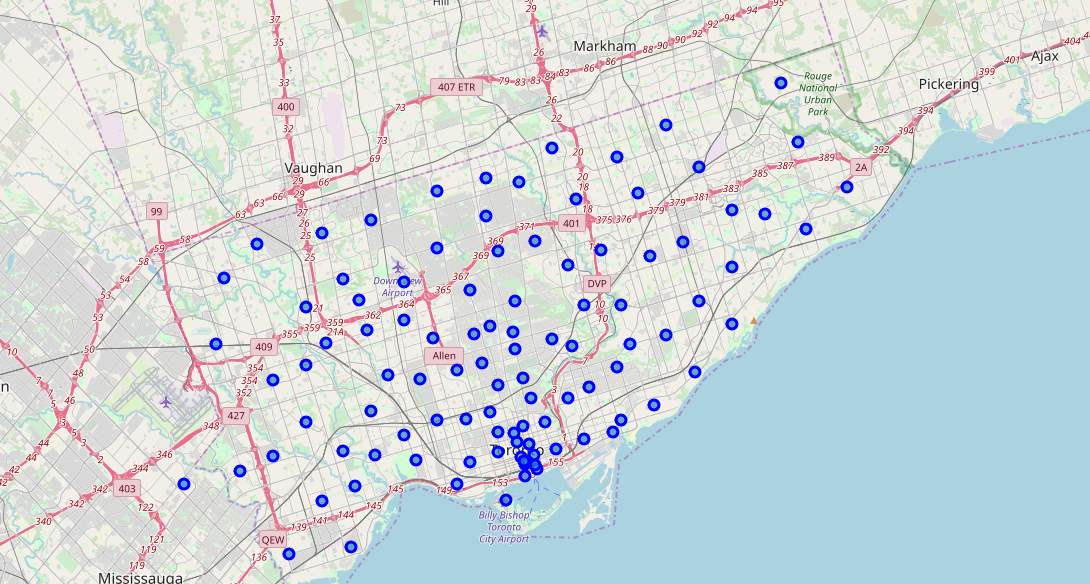

In [3]:
Image(filename='toronto.png')

Drop the PostalCode Column.

In [137]:
del toronto_city_data['PostalCode']
toronto_city_data

Borough                                       Neighborhood  \
0         Scarborough                                     Rouge, Malvern   
1         Scarborough             Highland Creek, Rouge Hill, Port Union   
2         Scarborough                  Guildwood, Morningside, West Hill   
3         Scarborough                                             Woburn   
4         Scarborough                                          Cedarbrae   
5         Scarborough                                Scarborough Village   
6         Scarborough        East Birchmount Park, Ionview, Kennedy Park   
7         Scarborough                    Clairlea, Golden Mile, Oakridge   
8         Scarborough    Cliffcrest, Cliffside, Scarborough Village West   
9         Scarborough                        Birch Cliff, Cliffside West   
10        Scarborough  Dorset Park, Scarborough Town Centre, Wexford ...   
11        Scarborough                                  Maryvale, Wexford   
12        Scarborough                                          Agincourt   
13        Scarborough            Clarks Corners, Sullivan, Tam O'Shanter   
14        Scarborough  Agincourt North, L'Amoreaux East, Milliken, St...   
15        Scarborough                      L'Amoreaux West, Steeles West   
16        Scarborough                                        Upper Rouge   
17         North York                                  Hillcrest Village   
18         North York                       Fairview, Henry Farm, Oriole   
19         North York                                    Bayview Village   
20         North York                           Silver Hills, York Mills   
21         North York                            Newtonbrook, Willowdale   
22         North York                                   Willowdale South   
23         North York                                    York Mills West   
24         North York                                    Willowdale West   
25         North York                                          Parkwoods   
26         North York                                    Don Mills North   
27         North York                   Flemingdon Park, Don Mills South   
28         North York    Bathurst Manor, Downsview North, Wilson Heights   
29         North York                    Northwood Park, York University   
30         North York                        CFB Toronto, Downsview East   
31         North York                                     Downsview West   
32         North York                                  Downsview Central   
33         North York                                Downsview Northwest   
34         North York                                   Victoria Village   
35          East York                    Woodbine Gardens, Parkview Hill   
36          East York                                   Woodbine Heights   
37       East Toronto                                        The Beaches   
38          East York                                            Leaside   
39          East York                                   Thorncliffe Park   
40          East York                                       East Toronto   
41       East Toronto                       The Danforth West, Riverdale   
42       East Toronto                     The Beaches West, India Bazaar   
43       East Toronto                                    Studio District   
44    Central Toronto                                      Lawrence Park   
45    Central Toronto                                   Davisville North   
46    Central Toronto                                 North Toronto West   
47    Central Toronto                                         Davisville   
48    Central Toronto                        Moore Park, Summerhill East   
49    Central Toronto  Deer Park, Forest Hill SE, Rathnelly, South Hi...   
50   Downtown Toronto                                           Rosedale   
51   Downtown Toronto                        Cabbagetown, St. 

Utilize the Foursquare API to explore the neighborhoods in the City of Toronto and segment them. Create a new dataframe called toronto_venues.

In [138]:
toronto_venues = getNearbyVenues(names=toronto_city_data['Neighborhood'],
                                 latitudes=toronto_city_data['Latitude'],
                                 longitudes=toronto_city_data['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West, Steeles West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The D

Check the size of the resulting dataframe.

In [139]:
print(toronto_venues.shape)
toronto_venues.head()

(2233, 7)


Neighborhood  Neighborhood Latitude  \
0                          Rouge, Malvern              43.806686   
1  Highland Creek, Rouge Hill, Port Union              43.784535   
2       Guildwood, Morningside, West Hill              43.763573   
3       Guildwood, Morningside, West Hill              43.763573   
4       Guildwood, Morningside, West Hill              43.763573   

   Neighborhood Longitude                            Venue  Venue Latitude  \
0              -79.194353                          Wendy's       43.807448   
1              -79.160497            Royal Canadian Legion       43.782533   
2              -79.188711  Swiss Chalet Rotisserie & Grill       43.767697   
3              -79.188711                G & G Electronics       43.765309   
4              -79.188711                 Big Bite Burrito       43.766299   

   Venue Longitude        Venue Category  
0       -79.199056  Fast Food Restaurant  
1       -79.163085                   Bar  
2       -79.189914           Pizza Place  
3       -79.191537     Electronics Store  
4       -79.190720    Mexican Restaurant

See how many venues were returned for each neighborhood.

In [140]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Adelaide, King, Richmond                                              100   
Agincourt                                                               4   
Agincourt North, L'Amoreaux East, Milliken, Ste...                      2   
Albion Gardens, Beaumond Heights, Humbergate, J...                     10   
Alderwood, Long Branch                                                  8   
Bathurst Manor, Downsview North, Wilson Heights                        17   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      26   
Berczy Park                                                            56   
Birch Cliff, Cliffside West                                             4   
Bloordale Gardens, Eringate, Markland Wood, Old...                      6   
Brockton, Exhibition Place, Parkdale Village                           18   
Business Reply Mail Processing Centre 969 Eastern                      16   
CFB Toronto, Downsview East                                             4   
CN Tower, Bathurst Quay, Island airport, Harbou...                     14   
Cabbagetown, St. James Town                                            47   
Caledonia-Fairbanks                                                     6   
Canada Post Gateway Processing Centre                                  11   
Cedarbrae                                                               7   
Central Bay Street                                                     83   
Chinatown, Grange Park, Kensington Market                             100   
Christie                                                               16   
Church and Wellesley                                                   86   
Clairlea, Golden Mile, Oakridge                                         9   
Clarks Corners, Sullivan, Tam O'Shanter                                 9   
Cliffcrest, Cliffside, Scarborough Village West                         2   
Cloverdale, Islington, Martin Grove, Princess G...                      2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             36   
Davisville North                                                        7   
Deer Park, Forest Hill SE, Rathnelly, South Hil...                     14   
Del Ray, Keelesdale, Mount Dennis, Silverthorn                          4   
Design Exchange, Toronto Dominion Centre                              100   
Don Mills North                                                         6   
Dorset Park, Scarborough Town Centre, Wexford H...                      7   
Dovercourt Village, Dufferin                                           20   
Downsview Central                                                       4   
Downsview Northwest                                                     4   
Downsview West                                                          4   
East Birchmount Park, Ionview, Kennedy Park                             8   
East Toronto                                                            2   
Emery, Humberlea                                                        1   
Fairview, Henry Farm, Oriole                                           64   
First Canadian Place, Underground city                                100   
Flemingdon Park, Don Mills South                                       21   
Forest Hill North, Forest Hill West                                     4   
Glencairn                                                               4   
Guildwood, Morningside, West Hill                                       6   
Harbord, University of Toronto                                         34   
Harbourfront East, Toronto Islands, Union Station                     100   
Harbourfront, Regent Park                       

See how many unique categories can be curated from all the returned venues.

In [142]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 unique categories.


Analyze each neighborhood.

In [150]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

venue_neighborhood = toronto_onehot['Neighborhood']
toronto_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
toronto_onehot.insert(0, 'Neighborhood', venue_neighborhood)

toronto_onehot.head()


Neighborhood  Accessories Store  Adult Boutique  \
0                          Rouge, Malvern                  0               0   
1  Highland Creek, Rouge Hill, Port Union                  0               0   
2       Guildwood, Morningside, West Hill                  0               0   
3       Guildwood, Morningside, West Hill                  0               0   
4       Guildwood, Morningside, West Hill                  0               0   

   Afghan Restaurant  Airport  Airport Food Court  Airport Gate  \
0                  0        0                   0             0   
1                  0        0                   0             0   
2                  0        0                   0             0   
3                  0        0                   0             0   
4                  0        0                   0             0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Antique Shop  Aquarium  Arepa Restaurant  Art Gallery  Art Museum  \
0             0         0                 0            0           0   
1             0         0                 0            0           0   
2             0         0                 0            0           0   
3             0         0                 0            0           0   
4             0         0                 0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0              0          0           0           0       0     0    0   
1              0          0           0           0       0     0    1   
2              0          0           0           0       0     0    0   
3              0          0           0           0       0     0    0   
4              0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Beach  Beer Bar  Beer Store  Belgian Restaurant  Bike Shop  Bistro  \
0      0         0           0                   0          0       0   
1      0         0           0                   0          0       0   
2      0         0           0                   0          0       0   
3      0         0           0                   0          0       0   
4      0         0           0                   0          0       0   

   Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  \
0              0          0         0                     0               0   
1              0          0         0                     0               0   
2              0          0         0                     0               0   
3              0          0         0                     0               0   
4              0          0         0       

Examine the new dataframe size.

In [151]:
toronto_onehot.shape

(2233, 274)

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [202]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

Neighborhood  Accessories Store  \
0                            Adelaide, King, Richmond           0.000000   
1                                           Agincourt           0.000000   
2   Agincourt North, L'Amoreaux East, Milliken, St...           0.000000   
3   Albion Gardens, Beaumond Heights, Humbergate, ...           0.000000   
4                              Alderwood, Long Branch           0.000000   
5     Bathurst Manor, Downsview North, Wilson Heights           0.000000   
6                                     Bayview Village           0.000000   
7                   Bedford Park, Lawrence Manor East           0.000000   
8                                         Berczy Park           0.000000   
9                         Birch Cliff, Cliffside West           0.000000   
10  Bloordale Gardens, Eringate, Markland Wood, Ol...           0.000000   
11       Brockton, Exhibition Place, Parkdale Village           0.000000   
12  Business Reply Mail Processing Centre 969 Eastern           0.000000   
13                        CFB Toronto, Downsview East           0.000000   
14  CN Tower, Bathurst Quay, Island airport, Harbo...           0.000000   
15                        Cabbagetown, St. James Town           0.000000   
16                                Caledonia-Fairbanks           0.000000   
17              Canada Post Gateway Processing Centre           0.000000   
18                                          Cedarbrae           0.000000   
19                                 Central Bay Street           0.000000   
20          Chinatown, Grange Park, Kensington Market           0.000000   
21                                           Christie           0.000000   
22                               Church and Wellesley           0.000000   
23                    Clairlea, Golden Mile, Oakridge           0.000000   
24            Clarks Corners, Sullivan, Tam O'Shanter           0.000000   
25    Cliffcrest, Cliffside, Scarborough Village West           0.000000   
26  Cloverdale, Islington, Martin Grove, Princess ...           0.000000   
27                     Commerce Court, Victoria Hotel           0.000000   
28                                         Davisville           0.000000   
29                                   Davisville North           0.000000   
30  Deer Park, Forest Hill SE, Rathnelly, South Hi...           0.000000   
31     Del Ray, Keelesdale, Mount Dennis, Silverthorn           0.000000   
32           Design Exchange, Toronto Dominion Centre           0.000000   
33                                    Don Mills North           0.000000   
34  Dorset Park, Scarborough Town Centre, Wexford ...           0.000000   
35                       Dovercourt Village, Dufferin           0.000000   
36                                  Downsview Central           0.000000   
37                                Downsview Northwest           0.000000   
38                                     Downsview West           0.000000   
39        East Birchmount Park, Ionview, Kennedy Park           0.000000   
40                                       East Toronto           0.000000   
41                                   Emery, Humberlea           0.000000   
42                       Fairview, Henry Farm, Oriole           0.000000   
43             First Canadian Place, Underground city           0.000000   
44                   Flemingdon Park, Don Mills South           0.000000   
45                Forest Hill North, Forest Hill West           0.000000   
46                                          Glencairn           0.000000   
47                  Guildwood, Morningside, West Hill           0.000000   
48                     Harbord, University of Toronto           0.000000   
49  Harbourfront East, Toronto Islands, Union Station           0.000000   
50                          Harbourfront, Regent Park           0.000000   
51                      High Park, The Junction South           0.000000   
52           

Confirm the new size.

In [153]:
toronto_grouped.shape

(100, 274)

Print each neighborhood along with the top 5 most common venues.

In [154]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2      Thai Restaurant  0.04
3  American Restaurant  0.04
4           Steakhouse  0.04


----Agincourt----
                venue  freq
0        Skating Rink  0.25
1      Breakfast Spot  0.25
2              Lounge  0.25
3      Clothing Store  0.25
4  Miscellaneous Shop  0.00


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                venue  freq
0          Playground   0.5
1                Park   0.5
2   Accessories Store   0.0
3  Mexican Restaurant   0.0
4               Motel   0.0


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                  venue  freq
0         Grocery Store   0.2
1           Pizza Place   0.1
2              Pharmacy   0.1
3  Fast Food Restaurant   0.1
4        Sandwich Place   0.1


----Alderwood, Long Branch----
            venue  freq
0     Pizza P

4     Accessories Store  0.00


----Downsview West----
           venue  freq
0          Hotel  0.25
1  Moving Target  0.25
2           Bank  0.25
3  Shopping Mall  0.25
4          Motel  0.00


----East Birchmount Park, Ionview, Kennedy Park----
                venue  freq
0      Discount Store  0.25
1         Coffee Shop  0.12
2         Bus Station  0.12
3  Chinese Restaurant  0.12
4    Department Store  0.12


----East Toronto----
                venue  freq
0   Convenience Store   0.5
1                Park   0.5
2   Accessories Store   0.0
3  Mexican Restaurant   0.0
4               Motel   0.0


----Emery, Humberlea----
                             venue  freq
0                   Baseball Field   1.0
1                Accessories Store   0.0
2                            Motel   0.0
3              Monument / Landmark   0.0
4  Molecular Gastronomy Restaurant   0.0


----Fairview, Henry Farm, Oriole----
                  venue  freq
0        Clothing Store  0.16
1  Fast Food Restauran

                       venue  freq
0                 Playground   0.5
1          Convenience Store   0.5
2          Accessories Store   0.0
3  Middle Eastern Restaurant   0.0
4              Movie Theater   0.0


----Silver Hills, York Mills----
                venue  freq
0           Cafeteria   1.0
1  Miscellaneous Shop   0.0
2       Moving Target   0.0
3       Movie Theater   0.0
4               Motel   0.0


----St. James Town----
            venue  freq
0     Coffee Shop  0.07
1      Restaurant  0.06
2           Hotel  0.05
3            Café  0.05
4  Clothing Store  0.04


----Stn A PO Boxes 25 The Esplanade----
                venue  freq
0         Coffee Shop  0.09
1          Restaurant  0.05
2                Café  0.04
3               Hotel  0.03
4  Seafood Restaurant  0.03


----Studio District----
                 venue  freq
0                 Café  0.10
1          Coffee Shop  0.08
2               Bakery  0.05
3  American Restaurant  0.05
4   Italian Restaurant  0.05


----Th

Create the new  pandas dataframe and display the top 10 venues for each neighborhood.

In [156]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_venues_sorted

Neighborhood   1st Most Common Venue  \
0                            Adelaide, King, Richmond             Coffee Shop   
1                                           Agincourt                  Lounge   
2   Agincourt North, L'Amoreaux East, Milliken, St...              Playground   
3   Albion Gardens, Beaumond Heights, Humbergate, ...           Grocery Store   
4                              Alderwood, Long Branch             Pizza Place   
5     Bathurst Manor, Downsview North, Wilson Heights             Coffee Shop   
6                                     Bayview Village                    Café   
7                   Bedford Park, Lawrence Manor East             Coffee Shop   
8                                         Berczy Park             Coffee Shop   
9                         Birch Cliff, Cliffside West         College Stadium   
10  Bloordale Gardens, Eringate, Markland Wood, Ol...                Pharmacy   
11       Brockton, Exhibition Place, Parkdale Village                    Café   
12  Business Reply Mail Processing Centre 969 Eastern      Light Rail Station   
13                        CFB Toronto, Downsview East       Electronics Store   
14  CN Tower, Bathurst Quay, Island airport, Harbo...          Airport Lounge   
15                        Cabbagetown, St. James Town             Coffee Shop   
16                                Caledonia-Fairbanks                    Park   
17              Canada Post Gateway Processing Centre             Coffee Shop   
18                                          Cedarbrae      Athletics & Sports   
19                                 Central Bay Street             Coffee Shop   
20          Chinatown, Grange Park, Kensington Market                    Café   
21                                           Christie           Grocery Store   
22                               Church and Wellesley     Japanese Restaurant   
23                    Clairlea, Golden Mile, Oakridge                Bus Line   
24            Clarks Corners, Sullivan, Tam O'Shanter             Pizza Place   
25    Cliffcrest, Cliffside, Scarborough Village West                   Motel   
26  Cloverdale, Islington, Martin Grove, Princess ...                    Bank   
27                     Commerce Court, Victoria Hotel             Coffee Shop   
28                                         Davisville            Dessert Shop   
29                                   Davisville North       Food & Drink Shop   
30  Deer Park, Forest Hill SE, Rathnelly, South Hi...             Coffee Shop   
31     Del Ray, Keelesdale, Mount Dennis, Silverthorn             Coffee Shop   
32           Design Exchange, Toronto Dominion Centre             Coffee Shop   
33                                    Don Mills North                    Café   
34  Dorset Park, Scarborough Town Centre, Wexford ...       Indian Restaurant   
35                       Dovercourt Village, Dufferin                Pharmacy   
36                                  Downsview Central       Korean Restaurant   
37                                Downsview Northwest      Athletics & Sports   
38                                     Downsview West           Moving Target   
39        East Birchmount Park, Ionview, Kennedy Park          Discount Store   
40                                       East Toronto                    Park   
41                                   Emery, Humberlea          Baseball Field   
42                       Fairview, Henry Farm, Oriole          Clothing Store   
43             First Canadian Place, Underground city             Coffee Shop   
44                   Flemingdon Park, Don Mills South              Beer Store   
45                Forest Hill North, Forest Hill West                   Trail   
46                                          Glencairn           Metro Station   
47                  Guildwood, Morningside, West Hill             Pizza Place   
48                     Harbord, University of Toronto                   

Cluster Neighborhoods.

Combine the sorted dataframes for the East Village and Toronto neighborhoods.

In [167]:
frames = [east_village_venues_sorted, toronto_venues_sorted]
combined_venues_sorted = pd.concat(frames, ignore_index=True)
combined_venues_sorted

Neighborhood  \
0                                         East Village   
1                             Adelaide, King, Richmond   
2                                            Agincourt   
3    Agincourt North, L'Amoreaux East, Milliken, St...   
4    Albion Gardens, Beaumond Heights, Humbergate, ...   
5                               Alderwood, Long Branch   
6      Bathurst Manor, Downsview North, Wilson Heights   
7                                      Bayview Village   
8                    Bedford Park, Lawrence Manor East   
9                                          Berczy Park   
10                         Birch Cliff, Cliffside West   
11   Bloordale Gardens, Eringate, Markland Wood, Ol...   
12        Brockton, Exhibition Place, Parkdale Village   
13   Business Reply Mail Processing Centre 969 Eastern   
14                         CFB Toronto, Downsview East   
15   CN Tower, Bathurst Quay, Island airport, Harbo...   
16                         Cabbagetown, St. James Town   
17                                 Caledonia-Fairbanks   
18               Canada Post Gateway Processing Centre   
19                                           Cedarbrae   
20                                  Central Bay Street   
21           Chinatown, Grange Park, Kensington Market   
22                                            Christie   
23                                Church and Wellesley   
24                     Clairlea, Golden Mile, Oakridge   
25             Clarks Corners, Sullivan, Tam O'Shanter   
26     Cliffcrest, Cliffside, Scarborough Village West   
27   Cloverdale, Islington, Martin Grove, Princess ...   
28                      Commerce Court, Victoria Hotel   
29                                          Davisville   
30                                    Davisville North   
31   Deer Park, Forest Hill SE, Rathnelly, South Hi...   
32      Del Ray, Keelesdale, Mount Dennis, Silverthorn   
33            Design Exchange, Toronto Dominion Centre   
34                                     Don Mills North   
35   Dorset Park, Scarborough Town Centre, Wexford ...   
36                        Dovercourt Village, Dufferin   
37                                   Downsview Central   
38                                 Downsview Northwest   
39                                      Downsview West   
40         East Birchmount Park, Ionview, Kennedy Park   
41                                        East Toronto   
42                                    Emery, Humberlea   
43                        Fairview, Henry Farm, Oriole   
44              First Canadian Place, Underground city   
45                    Flemingdon Park, Don Mills South   
46                 Forest Hill North, Forest Hill West   
47                                           Glencairn   
48                   Guildwood, Morningside, West Hill   
49                      Harbord, University of Toronto   
50   Harbourfront East, Toronto Islands, Union Station   
51                           Harbourfront, Regent Park   
52                       High Park, The Junction South   
53              Highland Creek, Rouge Hill, Port Union   
54                                   Hillcrest Village   
55        Humber Bay Shores, Mimico South, New Toronto   
56   Humber Bay, King's Mill Park, Kingsway Park So...   
57                                       Humber Summit   
58                                  Humewood-Cedarvale   
59   Kingsview Village, Martin Grove Gardens, Richv...   
60   Kingsway Park South West, Mimico NW, The Queen...   
61                       L'Amoreaux West, Steeles West   
62                    Lawrence Heights, Lawrence Manor   
63                                       Lawrence Park   
64                                             Leaside   
65                            Little Portugal, Trinity   
66            Maple Leaf Park, North Park, Upwood Park   
67                                   Maryvale, Wexford   
68                         Moore Park, S

Combine the grouped dataframes for the East Village and Toronto neighborhoods.

In [208]:
all_neighborhoods_grouped = east_village_grouped.append(toronto_grouped, ignore_index=True, sort=True)

all_neighborhood_venues = all_neighborhoods_grouped['Neighborhood']
all_neighborhoods_grouped.drop(labels=['Neighborhood'], axis=1,inplace = True)
all_neighborhoods_grouped.insert(0, 'Neighborhood', all_neighborhood_venues)

all_neighborhoods_grouped = all_neighborhoods_grouped.fillna(0)

all_neighborhoods_grouped

Neighborhood  Accessories Store  \
0                                         East Village           0.000000   
1                             Adelaide, King, Richmond           0.000000   
2                                            Agincourt           0.000000   
3    Agincourt North, L'Amoreaux East, Milliken, St...           0.000000   
4    Albion Gardens, Beaumond Heights, Humbergate, ...           0.000000   
5                               Alderwood, Long Branch           0.000000   
6      Bathurst Manor, Downsview North, Wilson Heights           0.000000   
7                                      Bayview Village           0.000000   
8                    Bedford Park, Lawrence Manor East           0.000000   
9                                          Berczy Park           0.000000   
10                         Birch Cliff, Cliffside West           0.000000   
11   Bloordale Gardens, Eringate, Markland Wood, Ol...           0.000000   
12        Brockton, Exhibition Place, Parkdale Village           0.000000   
13   Business Reply Mail Processing Centre 969 Eastern           0.000000   
14                         CFB Toronto, Downsview East           0.000000   
15   CN Tower, Bathurst Quay, Island airport, Harbo...           0.000000   
16                         Cabbagetown, St. James Town           0.000000   
17                                 Caledonia-Fairbanks           0.000000   
18               Canada Post Gateway Processing Centre           0.000000   
19                                           Cedarbrae           0.000000   
20                                  Central Bay Street           0.000000   
21           Chinatown, Grange Park, Kensington Market           0.000000   
22                                            Christie           0.000000   
23                                Church and Wellesley           0.000000   
24                     Clairlea, Golden Mile, Oakridge           0.000000   
25             Clarks Corners, Sullivan, Tam O'Shanter           0.000000   
26     Cliffcrest, Cliffside, Scarborough Village West           0.000000   
27   Cloverdale, Islington, Martin Grove, Princess ...           0.000000   
28                      Commerce Court, Victoria Hotel           0.000000   
29                                          Davisville           0.000000   
30                                    Davisville North           0.000000   
31   Deer Park, Forest Hill SE, Rathnelly, South Hi...           0.000000   
32      Del Ray, Keelesdale, Mount Dennis, Silverthorn           0.000000   
33            Design Exchange, Toronto Dominion Centre           0.000000   
34                                     Don Mills North           0.000000   
35   Dorset Park, Scarborough Town Centre, Wexford ...           0.000000   
36                        Dovercourt Village, Dufferin           0.000000   
37                                   Downsview Central           0.000000   
38                                 Downsview Northwest           0.000000   
39                                      Downsview West           0.000000   
40         East Birchmount Park, Ionview, Kennedy Park           0.000000   
41                                        East Toronto           0.000000   
42                                    Emery, Humberlea           0.000000   
43                        Fairview, Henry Farm, Oriole           0.000000   
44              First Canadian Place, Underground city           0.000000   
45                    Flemingdon Park, Don Mills South           0.000000   
46                 Forest Hill North, Forest Hill West           0.000000   
47                                           Glencairn           0.000000   
48                   Guildwood, Morningside, West Hill           0.000000   
49                      Harbord, University of Toronto           0.000000   
50   Harbourfront East, Toronto Islands, Union Station           0.000000   
51                           Harbourfr

Run k-means to cluster the neighborhood into 6 clusters.

In [260]:
# set number of clusters
kclusters = 6

all_neighborhoods_grouped_clustering = all_neighborhoods_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_neighborhoods_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 5, 5, 1, 5, 5, 5, 0, 5, 5])

Combine the grouped dataframes for the East Village and Toronto neighborhoods.

In [261]:
g_frames = [east_village, toronto_city_data]
combined_venues_data = pd.concat(g_frames, ignore_index=True)
combined_venues_data

Borough                                       Neighborhood  \
0           Manhattan                                       East Village   
1         Scarborough                                     Rouge, Malvern   
2         Scarborough             Highland Creek, Rouge Hill, Port Union   
3         Scarborough                  Guildwood, Morningside, West Hill   
4         Scarborough                                             Woburn   
5         Scarborough                                          Cedarbrae   
6         Scarborough                                Scarborough Village   
7         Scarborough        East Birchmount Park, Ionview, Kennedy Park   
8         Scarborough                    Clairlea, Golden Mile, Oakridge   
9         Scarborough    Cliffcrest, Cliffside, Scarborough Village West   
10        Scarborough                        Birch Cliff, Cliffside West   
11        Scarborough  Dorset Park, Scarborough Town Centre, Wexford ...   
12        Scarborough                                  Maryvale, Wexford   
13        Scarborough                                          Agincourt   
14        Scarborough            Clarks Corners, Sullivan, Tam O'Shanter   
15        Scarborough  Agincourt North, L'Amoreaux East, Milliken, St...   
16        Scarborough                      L'Amoreaux West, Steeles West   
17        Scarborough                                        Upper Rouge   
18         North York                                  Hillcrest Village   
19         North York                       Fairview, Henry Farm, Oriole   
20         North York                                    Bayview Village   
21         North York                           Silver Hills, York Mills   
22         North York                            Newtonbrook, Willowdale   
23         North York                                   Willowdale South   
24         North York                                    York Mills West   
25         North York                                    Willowdale West   
26         North York                                          Parkwoods   
27         North York                                    Don Mills North   
28         North York                   Flemingdon Park, Don Mills South   
29         North York    Bathurst Manor, Downsview North, Wilson Heights   
30         North York                    Northwood Park, York University   
31         North York                        CFB Toronto, Downsview East   
32         North York                                     Downsview West   
33         North York                                  Downsview Central   
34         North York                                Downsview Northwest   
35         North York                                   Victoria Village   
36          East York                    Woodbine Gardens, Parkview Hill   
37          East York                                   Woodbine Heights   
38       East Toronto                                        The Beaches   
39          East York                                            Leaside   
40          East York                                   Thorncliffe Park   
41          East York                                       East Toronto   
42       East Toronto                       The Danforth West, Riverdale   
43       East Toronto                     The Beaches West, India Bazaar   
44       East Toronto                                    Studio District   
45    Central Toronto                                      Lawrence Park   
46    Central Toronto                                   Davisville North   
47    Central Toronto                                 North Toronto West   
48    Central Toronto                                         Davisville   
49    Central Toronto                        Moore Park, Summerhill East   
50    Central Toronto  Deer Park, Forest Hill SE, Rathnelly, South Hi...   
51   Downtown Toronto                                         

## Results

Create a new dataframe that includes the cluster, as well as the top 10 venues for each neighborhood.

In [262]:
combined_neighborhoods_cluster = combined_venues_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
combined_neighborhoods_cluster = combined_neighborhoods_cluster.join(combined_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

combined_neighborhoods_cluster = combined_neighborhoods_cluster.dropna(axis=0).reset_index(drop=True)

# add clustering labels
combined_neighborhoods_cluster['Cluster Labels'] = kmeans.labels_

combined_neighborhoods_cluster

Borough                                       Neighborhood  \
0           Manhattan                                       East Village   
1         Scarborough                                     Rouge, Malvern   
2         Scarborough             Highland Creek, Rouge Hill, Port Union   
3         Scarborough                  Guildwood, Morningside, West Hill   
4         Scarborough                                             Woburn   
5         Scarborough                                          Cedarbrae   
6         Scarborough                                Scarborough Village   
7         Scarborough        East Birchmount Park, Ionview, Kennedy Park   
8         Scarborough                    Clairlea, Golden Mile, Oakridge   
9         Scarborough    Cliffcrest, Cliffside, Scarborough Village West   
10        Scarborough                        Birch Cliff, Cliffside West   
11        Scarborough  Dorset Park, Scarborough Town Centre, Wexford ...   
12        Scarborough                                  Maryvale, Wexford   
13        Scarborough                                          Agincourt   
14        Scarborough            Clarks Corners, Sullivan, Tam O'Shanter   
15        Scarborough  Agincourt North, L'Amoreaux East, Milliken, St...   
16        Scarborough                      L'Amoreaux West, Steeles West   
17         North York                                  Hillcrest Village   
18         North York                       Fairview, Henry Farm, Oriole   
19         North York                                    Bayview Village   
20         North York                           Silver Hills, York Mills   
21         North York                                   Willowdale South   
22         North York                                    York Mills West   
23         North York                                    Willowdale West   
24         North York                                          Parkwoods   
25         North York                                    Don Mills North   
26         North York                   Flemingdon Park, Don Mills South   
27         North York    Bathurst Manor, Downsview North, Wilson Heights   
28         North York                    Northwood Park, York University   
29         North York                        CFB Toronto, Downsview East   
30         North York                                     Downsview West   
31         North York                                  Downsview Central   
32         North York                                Downsview Northwest   
33         North York                                   Victoria Village   
34          East York                    Woodbine Gardens, Parkview Hill   
35          East York                                   Woodbine Heights   
36       East Toronto                                        The Beaches   
37          East York                                            Leaside   
38          East York                                   Thorncliffe Park   
39          East York                                       East Toronto   
40       East Toronto                       The Danforth West, Riverdale   
41       East Toronto                     The Beaches West, India Bazaar   
42       East Toronto                                    Studio District   
43    Central Toronto                                      Lawrence Park   
44    Central Toronto                                   Davisville North   
45    Central Toronto                                 North Toronto West   
46    Central Toronto                                         Davisville   
47    Central Toronto                        Moore Park, Summerhill East   
48    Central Toronto  Deer Park, Forest Hill SE, Rathnelly, South Hi...   
49   Downtown Toronto                                           Rosedale   
50   Downtown Toronto                        Cabbagetown, St. James Town   
51   Downtown Toronto                               Church and

Examine Clusters

Cluster 0

In [248]:
combined_neighborhoods_cluster.loc[combined_neighborhoods_cluster['Cluster Labels'] == 0, combined_neighborhoods_cluster.columns[[1] + list(range(4, combined_neighborhoods_cluster.shape[1]))]]

Neighborhood 1st Most Common Venue  \
7          East Birchmount Park, Ionview, Kennedy Park        Discount Store   
13                                           Agincourt                Lounge   
14             Clarks Corners, Sullivan, Tam O'Shanter           Pizza Place   
15   Agincourt North, L'Amoreaux East, Milliken, St...            Playground   
17                                   Hillcrest Village    Athletics & Sports   
19                                     Bayview Village                  Café   
24                                           Parkwoods     Food & Drink Shop   
26                    Flemingdon Park, Don Mills South            Beer Store   
27     Bathurst Manor, Downsview North, Wilson Heights           Coffee Shop   
30                                      Downsview West         Moving Target   
34                     Woodbine Gardens, Parkview Hill  Fast Food Restaurant   
38                                    Thorncliffe Park     Indian Restaurant   
39                                        East Toronto                  Park   
46                                          Davisville          Dessert Shop   
53                            Ryerson, Garden District           Coffee Shop   
54                                      St. James Town           Coffee Shop   
58   Harbourfront East, Toronto Islands, Union Station           Coffee Shop   
60                      Commerce Court, Victoria Hotel           Coffee Shop   
63                 Forest Hill North, Forest Hill West                 Trail   
66           Chinatown, Grange Park, Kensington Market                  Café   
68                     Stn A PO Boxes 25 The Esplanade           Coffee Shop   
70                    Lawrence Heights, Lawrence Manor        Clothing Store   
73                                 Caledonia-Fairbanks                  Park   
76                            Little Portugal, Trinity                   Bar   
77        Brockton, Exhibition Place, Parkdale Village                  Café   
80                       The Junction North, Runnymede           Pizza Place   
81                       High Park, The Junction South    Mexican Restaurant   
87        Humber Bay Shores, Mimico South, New Toronto              Pharmacy   
90   Humber Bay, King's Mill Park, Kingsway Park So...        Baseball Field   
98   Kingsview Village, Martin Grove Gardens, Richv...           Pizza Place   
100                                          Northwest                   Bar   

          2nd Most Common Venue       3rd Most Common Venue  \
7              Department Store           Convenience Store   
13               Clothing Store                Skating Rink   
14                     Pharmacy             Thai Restaurant   
15                         Park                 Yoga Studio   
17                      Dog Run    Mediterranean Restaurant   
19          Japanese Restaurant                        Bank   
24                         Park  Construction & Landscaping   
26                          Gym            Asian Restaurant   
27          Fried Chicken Joint                 Pizza Place   
30                Shopping Mall                       Hotel   
34                  Pizza Place                    Pharmacy   
38                  Yoga Studio                 Supermarket   
39            Convenience Store                 Yoga Studio   
46               Sandwich Place                 Pizza Place   
53               Clothing Store                        Café   
54                   Restaurant                       Hotel   
58                        Hotel                    Aquarium   
60                         Café                       Hotel   
63                         Park            Sushi Restaurant   
66                          Bar       Vietnamese Restaurant   
68                   Restaurant                        Café   
70            Accessories Store                    Boutique   
73                     Pharmacy 

Cluster 1

In [249]:
combined_neighborhoods_cluster.loc[combined_neighborhoods_cluster['Cluster Labels'] == 1, combined_neighborhoods_cluster.columns[[1] + list(range(4, combined_neighborhoods_cluster.shape[1]))]]

Neighborhood 1st Most Common Venue  \
3   Guildwood, Morningside, West Hill           Pizza Place   
75       Dovercourt Village, Dufferin              Pharmacy   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
3    Rental Car Location     Electronics Store        Breakfast Spot   
75           Supermarket                Bakery  Gym / Fitness Center   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
3         Medical Center    Mexican Restaurant           Yoga Studio   
75                  Pool               Brewery  Fast Food Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
3             Donut Shop        Discount Store                Dog Run   
75        Discount Store                   Bar                   Bank   

    Cluster Labels  
3                1  
75               1

Cluster 2

In [250]:
combined_neighborhoods_cluster.loc[combined_neighborhoods_cluster['Cluster Labels'] == 2, combined_neighborhoods_cluster.columns[[1] + list(range(4, combined_neighborhoods_cluster.shape[1]))]]

Neighborhood 1st Most Common Venue  \
57                  Adelaide, King, Richmond           Coffee Shop   
59  Design Exchange, Toronto Dominion Centre           Coffee Shop   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
57                  Café   American Restaurant            Steakhouse   
59                 Hotel                  Café            Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
57       Thai Restaurant      Asian Restaurant                   Bar   
59   American Restaurant         Deli / Bodega                   Gym   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
57            Restaurant                Bakery                    Gym   
59    Italian Restaurant             Gastropub    Japanese Restaurant   

    Cluster Labels  
57               2  
59               2

Cluster 3

In [251]:
combined_neighborhoods_cluster.loc[combined_neighborhoods_cluster['Cluster Labels'] == 3, combined_neighborhoods_cluster.columns[[1] + list(range(4, combined_neighborhoods_cluster.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
42     Studio District                  Café           Coffee Shop   
56  Central Bay Street           Coffee Shop                  Café   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
42                Bakery    Italian Restaurant   American Restaurant   
56    Italian Restaurant          Burger Joint                   Bar   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
42           Yoga Studio           Fish Market             Juice Bar   
56        Sandwich Place           Salad Place        Ice Cream Shop   

   9th Most Common Venue 10th Most Common Venue  Cluster Labels  
42             Bookstore      Convenience Store               3  
56     Indian Restaurant                    Spa               3

Cluster 4

In [252]:
combined_neighborhoods_cluster.loc[combined_neighborhoods_cluster['Cluster Labels'] == 4, combined_neighborhoods_cluster.columns[[1] + list(range(4, combined_neighborhoods_cluster.shape[1]))]]

Neighborhood 1st Most Common Venue  \
41  The Beaches West, India Bazaar                  Park   
94                   Humber Summit           Pizza Place   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
41                   Gym        Sandwich Place            Steakhouse   
94   Empanada Restaurant           Yoga Studio             Drugstore   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
41        Ice Cream Shop    Italian Restaurant                   Pub   
94                 Diner        Discount Store               Dog Run   

   8th Most Common Venue 9th Most Common Venue       10th Most Common Venue  \
41         Burrito Place     Fish & Chips Shop                Movie Theater   
94      Doner Restaurant            Donut Shop  Eastern European Restaurant   

    Cluster Labels  
41               4  
94               4

Cluster 5

In [253]:
combined_neighborhoods_cluster.loc[combined_neighborhoods_cluster['Cluster Labels'] == 5, combined_neighborhoods_cluster.columns[[1] + list(range(4, combined_neighborhoods_cluster.shape[1]))]]

Neighborhood   1st Most Common Venue  \
0                                        East Village          Ice Cream Shop   
1                                      Rouge, Malvern    Fast Food Restaurant   
2              Highland Creek, Rouge Hill, Port Union                     Bar   
4                                              Woburn             Coffee Shop   
5                                           Cedarbrae      Athletics & Sports   
6                                 Scarborough Village              Playground   
8                     Clairlea, Golden Mile, Oakridge                Bus Line   
9     Cliffcrest, Cliffside, Scarborough Village West                   Motel   
10                        Birch Cliff, Cliffside West         College Stadium   
11  Dorset Park, Scarborough Town Centre, Wexford ...       Indian Restaurant   
12                                  Maryvale, Wexford             Auto Garage   
16                      L'Amoreaux West, Steeles West    Fast Food Restaurant   
18                       Fairview, Henry Farm, Oriole          Clothing Store   
20                           Silver Hills, York Mills               Cafeteria   
21                                   Willowdale South        Ramen Restaurant   
22                                    York Mills West                     Bar   
23                                    Willowdale West                Pharmacy   
25                                    Don Mills North                    Café   
28                    Northwood Park, York University  Furniture / Home Store   
29                        CFB Toronto, Downsview East       Electronics Store   
31                                  Downsview Central       Korean Restaurant   
32                                Downsview Northwest      Athletics & Sports   
33                                   Victoria Village             Pizza Place   
35                                   Woodbine Heights                Pharmacy   
36                                        The Beaches        Asian Restaurant   
37                                            Leaside             Coffee Shop   
40                       The Danforth West, Riverdale        Greek Restaurant   
43                                      Lawrence Park                Bus Line   
44                                   Davisville North       Food & Drink Shop   
45                                 North Toronto West             Coffee Shop   
47                        Moore Park, Summerhill East                     Gym   
48  Deer Park, Forest Hill SE, Rathnelly, South Hi...             Coffee Shop   
49                                           Rosedale                    Park   
50                        Cabbagetown, St. James Town             Coffee Shop   
51                               Church and Wellesley     Japanese Restaurant   
52                          Harbourfront, Regent Park             Coffee Shop   
55                                        Berczy Park             Coffee Shop   
61                  Bedford Park, Lawrence Manor East             Coffee Shop   
62                                           Roselawn                  Garden   
64                The Annex, North Midtown, Yorkville                    Café   
65                     Harbord, University of Toronto                    Café   
67  CN Tower, Bathurst Quay, Island airport, Harbo...          Airport Lounge   
69             First Canadian Place, Underground city             Coffee Shop   
71                                          Glencairn           Metro Station   
72                                 Humewood-Cedarvale                   Field   
74                                           Christie           Grocery Store   
78           Maple Leaf Park, North Park, Upwood Park                    Park   
79     Del Ray, Keelesdale, Mount Dennis, Silverthorn             Coffee Shop   
82                             Parkdale, Roncesvalles          Breakfast

Convert Cluster 5 output to a HTML table for the report.

In [279]:
cluster_5 = combined_neighborhoods_cluster.loc[combined_neighborhoods_cluster['Cluster Labels'] == 5, combined_neighborhoods_cluster.columns[[1] + list(range(4, combined_neighborhoods_cluster.shape[1]))]]
cluster_5 = cluster_5.drop('Cluster Labels', axis=1)
cluster_5.to_html('cluster_5.html')

Visualize the resluting clusters

Remove East Village from the dataframe, as to only identify Toronto neighborhoods.

In [254]:
combined_neighborhoods_cluster = combined_neighborhoods_cluster[combined_neighborhoods_cluster.Neighborhood != 'East Village']
combined_neighborhoods_cluster

Borough                                       Neighborhood  \
1         Scarborough                                     Rouge, Malvern   
2         Scarborough             Highland Creek, Rouge Hill, Port Union   
3         Scarborough                  Guildwood, Morningside, West Hill   
4         Scarborough                                             Woburn   
5         Scarborough                                          Cedarbrae   
6         Scarborough                                Scarborough Village   
7         Scarborough        East Birchmount Park, Ionview, Kennedy Park   
8         Scarborough                    Clairlea, Golden Mile, Oakridge   
9         Scarborough    Cliffcrest, Cliffside, Scarborough Village West   
10        Scarborough                        Birch Cliff, Cliffside West   
11        Scarborough  Dorset Park, Scarborough Town Centre, Wexford ...   
12        Scarborough                                  Maryvale, Wexford   
13        Scarborough                                          Agincourt   
14        Scarborough            Clarks Corners, Sullivan, Tam O'Shanter   
15        Scarborough  Agincourt North, L'Amoreaux East, Milliken, St...   
16        Scarborough                      L'Amoreaux West, Steeles West   
17         North York                                  Hillcrest Village   
18         North York                       Fairview, Henry Farm, Oriole   
19         North York                                    Bayview Village   
20         North York                           Silver Hills, York Mills   
21         North York                                   Willowdale South   
22         North York                                    York Mills West   
23         North York                                    Willowdale West   
24         North York                                          Parkwoods   
25         North York                                    Don Mills North   
26         North York                   Flemingdon Park, Don Mills South   
27         North York    Bathurst Manor, Downsview North, Wilson Heights   
28         North York                    Northwood Park, York University   
29         North York                        CFB Toronto, Downsview East   
30         North York                                     Downsview West   
31         North York                                  Downsview Central   
32         North York                                Downsview Northwest   
33         North York                                   Victoria Village   
34          East York                    Woodbine Gardens, Parkview Hill   
35          East York                                   Woodbine Heights   
36       East Toronto                                        The Beaches   
37          East York                                            Leaside   
38          East York                                   Thorncliffe Park   
39          East York                                       East Toronto   
40       East Toronto                       The Danforth West, Riverdale   
41       East Toronto                     The Beaches West, India Bazaar   
42       East Toronto                                    Studio District   
43    Central Toronto                                      Lawrence Park   
44    Central Toronto                                   Davisville North   
45    Central Toronto                                 North Toronto West   
46    Central Toronto                                         Davisville   
47    Central Toronto                        Moore Park, Summerhill East   
48    Central Toronto  Deer Park, Forest Hill SE, Rathnelly, South Hi...   
49   Downtown Toronto                                           Rosedale   
50   Downtown Toronto                        Cabbagetown, St. James Town   
51   Downtown Toronto                               Church and Wellesley   
52   Downtown Toronto                          Harbourfront, R

In [255]:
# create map
map_toronto_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(combined_neighborhoods_cluster['Latitude'], combined_neighborhoods_cluster['Longitude'], combined_neighborhoods_cluster['Neighborhood'], combined_neighborhoods_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto_clusters)

map_toronto_clusters.save('toronto_clusters.html')    
    
map_toronto_clusters

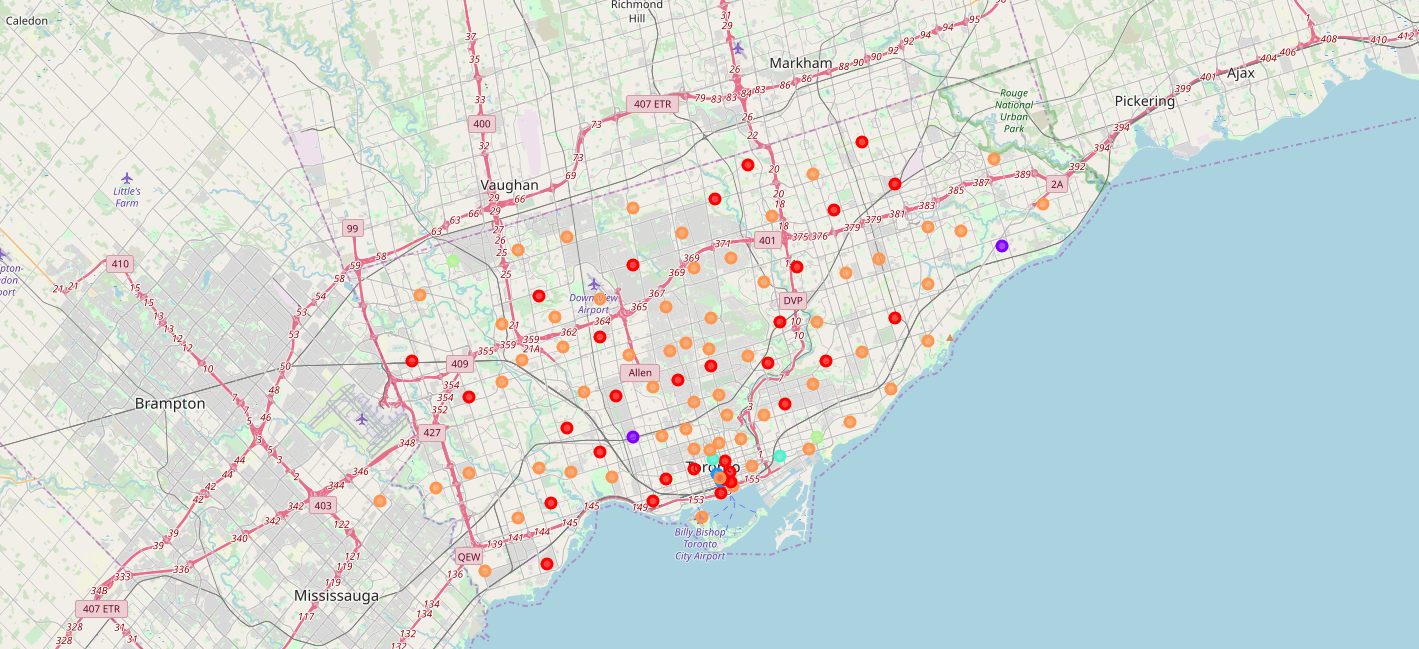

In [4]:
Image(filename='toronto_clusters.png')